# 네이버 영화 감성분석

In [1]:
import re

import numpy as np
import pandas as pd
import konlpy
import gensim

import tensorflow as tf
from konlpy.tag import Mecab

from collections import Counter


print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

2.0.0
0.6.0
4.3.1


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
NUM_WORDS = 10000
VOCAB_SIZE = 10000 
WORD_VECTOR_DIM = 300

## 데이터 불러오기

In [4]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('../data/ex8/ratings_train.txt')
test_data = pd.read_table('../data/ex8/ratings_test.txt')

train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


### 특수문자 전처리

In [5]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2. 특수문자 양쪽에 공백을 넣고
    sentence = re.sub(r'["."]+', "", sentence) # 3. 여러개의 공백은 하나의 공백으로 바꿉니다
    sentence = re.sub(r'[","]+', "", sentence) # 3. 여러개의 공백은 하나의 공백으로 바꿉니다
    sentence = re.sub(r'[" "]+', " ", sentence) # 3. 여러개의 공백은 하나의 공백으로 바꿉니다
    sentence = re.sub(r'["\n"]+', " ", sentence) # 3. 여러개의 공백은 하나의 공백으로 바꿉니다
    sentence = sentence.strip() # 5. 다시 양쪽 공백을 지웁니다
    return sentence

In [6]:
corpus = []
for sentence in train_data["document"]:
    sentence = str(sentence)
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
    
train_data["document"]=corpus

In [7]:
train_data["document"][:10]

0                                    아 더빙 진짜 짜증나네요 목소리
1                         흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                           교도소 이야기구먼 솔직히 재미는 없다 평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화 ! 스파이더맨에서 늙어보이기만 했던 커스...
5           막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화 ㅋㅋㅋ 별반개도 아까움
6                                 원작의 긴장감을 제대로 살려내지못했다
7    별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지 정말 발로해도 그것보단 ...
8                               액션이 없는데도 재미 있는 몇안되는 영화
9        왜케 평점이 낮은건데 ? 꽤 볼만한데 헐리우드식 화려함에만 너무 길들여져 있나 ?
Name: document, dtype: object

In [8]:
corpus = []
for sentence in test_data["document"]:
    sentence = str(sentence)
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
    
test_data["document"]=corpus

In [9]:
test_data["document"][:10]

0                                                  굳 ㅋ
1                                 gdntopclassintheclub
2                   뭐야 이 평점들은 나쁘진 않지만 10점 짜리는 더더욱 아니잖아
3                            지루하지는 않은데 완전 막장임 돈주고 보기에는
4    3d만 아니었어도 별 다섯 개 줬을텐데 왜 3d로 나와서 제 심기를 불편하게 하죠 ? ?
5                                    음악이 주가 된 최고의 음악영화
6                                              진정한 쓰레기
7             마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가 고개를 젖게한다
8    갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한c...
9          이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 but 모든 사람이 그렇지는 않네
Name: document, dtype: object

### 중복값 제거

In [10]:
train_data.duplicated(subset=["document"]).sum()

4802

In [11]:
train_data.drop_duplicates(subset=["document"],inplace=True)

In [12]:
test_data.duplicated(subset=["document"]).sum()

1088

In [13]:
test_data.drop_duplicates(subset=["document"],inplace=True)

### 결측치 제거

In [14]:
train_data.isna().sum()

id          0
document    0
label       0
dtype: int64

In [15]:
train_data.dropna(inplace=True)

In [16]:
test_data.isna().sum()

id          0
document    0
label       0
dtype: int64

In [17]:
test_data.dropna(inplace=True)

### 불용어 사전 불러오기

In [18]:
stopwords = []
f = open("../data/ex8/stopword.txt", 'r')
while True :
    line = f.readline().strip()
    if not line : break
    stopwords.append(line)
f.close

# stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

print("len : ", len(stopwords))
print("stopword sample :",stopwords[:30])

len :  684
stopword sample : ['않다', '되어다', '되다', '하다', '어떻다', '이렇다', '이다', '어제', '매일', '아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다', '의거하여']


### 한국어 데이터로 토큰화

In [19]:
tokenizer = Mecab()

X_train = []
for sentence in train_data['document']:
    temp_X = tokenizer.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [20]:
X_train[0:2]

[['더', '빙', '진짜', '짜증', '네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '가볍', '지', '않', '구나']]

In [21]:
X_test = []
for sentence in test_data['document']:
    temp_X = tokenizer.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [22]:
X_test[0:2]

[['굳', 'ㅋ'], ['gdntopclassintheclub']]

### 사전 제작 (word2index)

In [23]:
words = np.concatenate(X_train).tolist()
counter = Counter(words)
counter = counter.most_common(NUM_WORDS-4)
vocab = ['', '', '', ''] + [key for key, _ in counter]

word_to_index = {word:index for index, word in enumerate(vocab)}

In [24]:
for k, v in word_to_index.items():
    print(k, v)
    if v == 10: break

 3
는 4
영화 5
다 6
고 7
도 8
! 9
은 10


In [25]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

In [26]:
index_to_word[0],index_to_word[1],index_to_word[2],index_to_word[3]

('<PAD>', '<BOS>', '<UNK>', '<UNUSED>')

In [27]:
# 토큰화
def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

In [28]:
X_train = list(map(wordlist_to_indexlist, X_train))
X_test = list(map(wordlist_to_indexlist, X_test))

print(X_train[:2])
print(X_test[:2])

[[62, 853, 32, 199, 28, 665], [938, 461, 485, 611, 5, 100, 1508, 45, 907, 14, 35, 345]]
[[745, 110], [3]]


In [29]:
y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

print(y_train[:2])
print(y_test[:2])

[0 1]
[1 0]


In [30]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 문장길이 조절

In [31]:
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))
  
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
MAXLEN = int(max_tokens)
print('pad_sequences maxlen : ', MAXLEN)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens) * 100))

문장길이 평균 :  13.963103394982227
문장길이 최대 :  128
문장길이 표준편차 :  11.272674673956143
pad_sequences maxlen :  47
전체 문장의 97.19179846478801%가 maxlen 설정값 이내에 포함됩니다. 


In [32]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=MAXLEN)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=MAXLEN)

In [33]:
print("X_train.shape : ", X_train.shape)
print("X_test.shape : ", X_test.shape)

X_train.shape :  (145198, 47)
X_test.shape :  (48912, 47)


### valid set

In [34]:
# validation set 10000건 분리
train_size = int(len(X_train)*0.7)
print("train_size :", train_size)
X_val = X_train[train_size:]  
y_val = y_train[train_size:]

partial_X_train = X_train[:train_size]   
partial_y_train = y_train[:train_size]

print("\n train set")
print(partial_X_train.shape)
print(partial_y_train.shape)
print("\n valid set")
print(X_val.shape)
print(y_val.shape)

train_size : 101638

 train set
(101638, 47)
(101638,)

 valid set
(43560, 47)
(43560,)


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
def show_lcurve(hists, titles, colors=["r","g","b","k"], size=(12,4), x_itv=1, lw=1):
    plt.figure(figsize=size)
    # loss 
    plt.subplot(121)
    for i, hist in enumerate(hists):
        loss = hist.history['loss']
        val_loss = hist.history['val_loss']
        epochs = range(1, 1+len(loss))
        xbins = range(0, len(loss)+1, x_itv)
        plt.plot(epochs, loss, lw=lw,linestyle=':', label=f'{titles[i]} train loss', c=colors[i])
        plt.plot(epochs, val_loss, lw=lw,marker='.', label=f'{titles[i]} valid loss', c=colors[i])
        plt.legend();plt.grid(True);plt.xticks(xbins)
        plt.xlabel('Epochs');plt.ylabel('Loss')
        x, y = epochs[-1], hist.history['loss'][-1]
        plt.text(x, y, np.round(y,2), c=colors[i])
        x, y = epochs[-1], hist.history['val_loss'][-1]
        plt.text(x, y, np.round(y,2), c=colors[i])
    
    # acc
    plt.subplot(122)
    for i, hist in enumerate(hists):
        acc = hist.history['acc']
        val_acc = hist.history['val_acc']
        plt.plot(epochs, acc, linestyle=':', lw=lw,label=f'{titles[i]} train acc', c=colors[i])
        plt.plot(epochs, val_acc, marker='.', lw=lw,label=f'{titles[i]} valid acc', c=colors[i])
        plt.legend();plt.grid(True);plt.xticks(xbins)
        plt.xlabel('Epochs');plt.ylabel('Acc')
        x, y = epochs[-1], hist.history['acc'][-1]
        plt.text(x, y, np.round(y,2), c=colors[i])
        x, y = epochs[-1], hist.history['val_acc'][-1]
        plt.text(x, y, np.round(y,2), c=colors[i])
    plt.show()

## 모델

In [38]:
VOCAB_SIZE = 10000 
WORD_VECTOR_DIM = 300

### 1. GAP

In [117]:
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential(name="GAP")
model.add(tf.keras.layers.Input(shape=MAXLEN, name="Input"))
model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=WORD_VECTOR_DIM, name="EMB"))
model.add(tf.keras.layers.GlobalAveragePooling1D(name="GAP1d"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid", name="Classification"))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_acc",
                                        patience=3,
                                        factor=0.5)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])
model.summary()

Model: "GAP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EMB (Embedding)             (None, 47, 300)           3000000   
                                                                 
 GAP1d (GlobalAveragePooling  (None, 300)              0         
 1D)                                                             
                                                                 
 Classification (Dense)      (None, 1)                 301       
                                                                 
Total params: 3,000,301
Trainable params: 3,000,301
Non-trainable params: 0
_________________________________________________________________


In [118]:
epochs=20

history_gap = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr],
                    verbose=1)

Epoch 1/20
199/199 [==============================] - 2s 9ms/step - loss: 0.6061 - acc: 0.7563 - val_loss: 0.5152 - val_acc: 0.7956 - lr: 0.0010
Epoch 2/20
199/199 [==============================] - 2s 8ms/step - loss: 0.4536 - acc: 0.8196 - val_loss: 0.4190 - val_acc: 0.8230 - lr: 0.0010
Epoch 3/20
199/199 [==============================] - 2s 8ms/step - loss: 0.3872 - acc: 0.8394 - val_loss: 0.3861 - val_acc: 0.8346 - lr: 0.0010
Epoch 4/20
199/199 [==============================] - 2s 8ms/step - loss: 0.3619 - acc: 0.8491 - val_loss: 0.3754 - val_acc: 0.8393 - lr: 0.0010
Epoch 5/20
199/199 [==============================] - 2s 8ms/step - loss: 0.3500 - acc: 0.8544 - val_loss: 0.3717 - val_acc: 0.8416 - lr: 0.0010
Epoch 6/20
199/199 [==============================] - 2s 8ms/step - loss: 0.3424 - acc: 0.8577 - val_loss: 0.3722 - val_acc: 0.8403 - lr: 0.0010
Epoch 7/20
199/199 [==============================] - 2s 8ms/step - loss: 0.3372 - acc: 0.8607 - val_loss: 0.3685 - val_acc: 0.844

### 2. GMP

In [119]:
VOCAB_SIZE = 10000 
WORD_VECTOR_DIM = 300

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential(name="GMP")
model.add(tf.keras.layers.Input(shape=MAXLEN))
model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=WORD_VECTOR_DIM))
model.add(tf.keras.layers.GlobalMaxPooling1D(name="GMP1d"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_acc",
                                        patience=3,
                                        factor=0.5)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])
model.summary()

Model: "GMP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 47, 300)           3000000   
                                                                 
 GMP1d (GlobalMaxPooling1D)  (None, 300)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 301       
                                                                 
Total params: 3,000,301
Trainable params: 3,000,301
Non-trainable params: 0
_________________________________________________________________


In [120]:
epochs=20

history_gmp = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr],
                    verbose=1)

Epoch 1/20
199/199 [==============================] - 2s 8ms/step - loss: 0.5009 - acc: 0.8066 - val_loss: 0.3914 - val_acc: 0.8281 - lr: 0.0010
Epoch 2/20
199/199 [==============================] - 1s 7ms/step - loss: 0.3514 - acc: 0.8494 - val_loss: 0.3581 - val_acc: 0.8421 - lr: 0.0010
Epoch 3/20
199/199 [==============================] - 1s 7ms/step - loss: 0.3192 - acc: 0.8649 - val_loss: 0.3490 - val_acc: 0.8474 - lr: 0.0010
Epoch 4/20
199/199 [==============================] - 1s 7ms/step - loss: 0.3009 - acc: 0.8739 - val_loss: 0.3468 - val_acc: 0.8497 - lr: 0.0010
Epoch 5/20
199/199 [==============================] - 2s 8ms/step - loss: 0.2881 - acc: 0.8799 - val_loss: 0.3468 - val_acc: 0.8506 - lr: 0.0010
Epoch 6/20
199/199 [==============================] - 2s 8ms/step - loss: 0.2783 - acc: 0.8854 - val_loss: 0.3488 - val_acc: 0.8510 - lr: 0.0010
Epoch 7/20
199/199 [==============================] - 2s 8ms/step - loss: 0.2705 - acc: 0.8896 - val_loss: 0.3510 - val_acc: 0.849

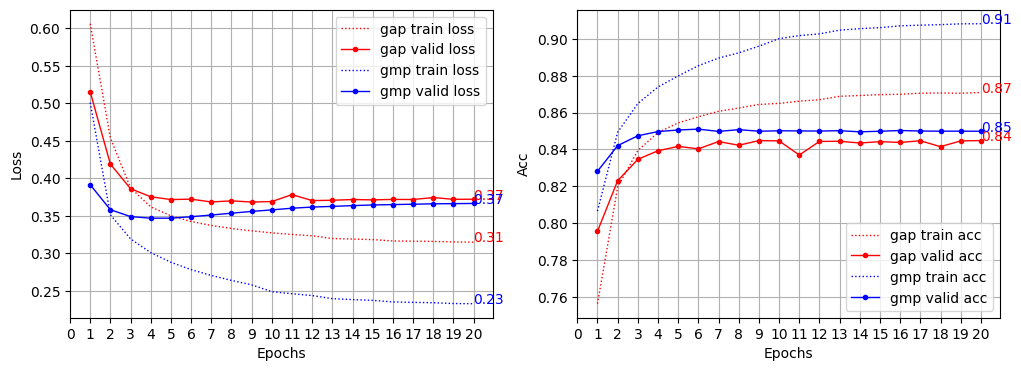

In [121]:
show_lcurve([history_gap, history_gmp], ["gap","gmp"],["r","b"])

### 3. LSTM 1

In [124]:
model = tf.keras.Sequential(name="LSTM_1")
model.add(tf.keras.layers.Input(shape=MAXLEN))
model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=WORD_VECTOR_DIM))
model.add(tf.keras.layers.LSTM(100, name="LSTM"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid", name="classifier"))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_acc",
                                        patience=3,
                                        factor=0.5)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])
model.summary()

Model: "LSTM_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 47, 300)           3000000   
                                                                 
 LSTM (LSTM)                 (None, 100)               160400    
                                                                 
 classifier (Dense)          (None, 1)                 101       
                                                                 
Total params: 3,160,501
Trainable params: 3,160,501
Non-trainable params: 0
_________________________________________________________________


In [125]:
epochs=20

history_lstm1 = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr],
                    verbose=1)

Epoch 1/20
199/199 [==============================] - 6s 18ms/step - loss: 0.4063 - acc: 0.8169 - val_loss: 0.3583 - val_acc: 0.8421 - lr: 0.0010
Epoch 2/20
199/199 [==============================] - 3s 16ms/step - loss: 0.3261 - acc: 0.8596 - val_loss: 0.3420 - val_acc: 0.8507 - lr: 0.0010
Epoch 3/20
199/199 [==============================] - 3s 16ms/step - loss: 0.2989 - acc: 0.8723 - val_loss: 0.3438 - val_acc: 0.8498 - lr: 0.0010
Epoch 4/20
199/199 [==============================] - 3s 16ms/step - loss: 0.2742 - acc: 0.8842 - val_loss: 0.3329 - val_acc: 0.8592 - lr: 0.0010
Epoch 5/20
199/199 [==============================] - 3s 16ms/step - loss: 0.2538 - acc: 0.8942 - val_loss: 0.3672 - val_acc: 0.8512 - lr: 0.0010
Epoch 6/20
199/199 [==============================] - 3s 16ms/step - loss: 0.2340 - acc: 0.9040 - val_loss: 0.3617 - val_acc: 0.8537 - lr: 0.0010
Epoch 7/20
199/199 [==============================] - 3s 15ms/step - loss: 0.2152 - acc: 0.9127 - val_loss: 0.3589 - val_acc

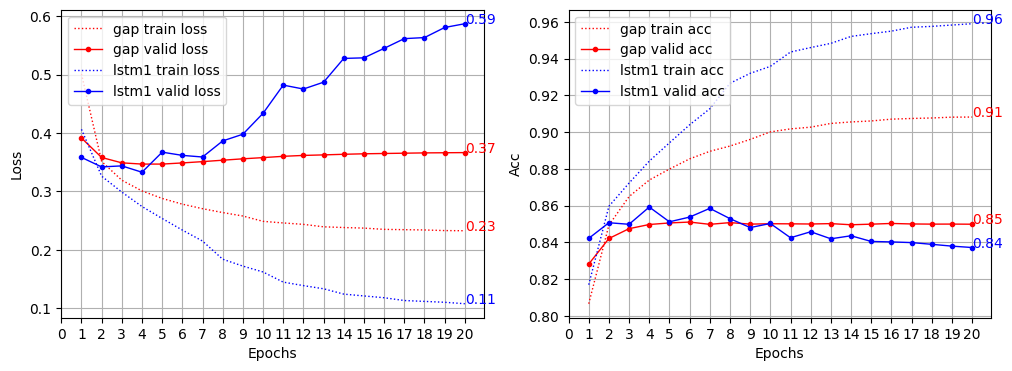

In [126]:
show_lcurve([history_gmp, history_lstm1], ["gap","lstm1"],["r","b"])

### 4. GRU 1

In [128]:
model = tf.keras.Sequential(name="GRU_1")
model.add(tf.keras.layers.Input(shape=MAXLEN))
model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=WORD_VECTOR_DIM))
model.add(tf.keras.layers.GRU(100, name="GRU"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid", name="classifier"))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_acc",
                                        patience=3,
                                        factor=0.5)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])
model.summary()

Model: "GRU_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 47, 300)           3000000   
                                                                 
 GRU (GRU)                   (None, 100)               120600    
                                                                 
 classifier (Dense)          (None, 1)                 101       
                                                                 
Total params: 3,120,701
Trainable params: 3,120,701
Non-trainable params: 0
_________________________________________________________________


In [129]:
epochs=20

history_gru1 = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr],
                    verbose=1)

Epoch 1/20
199/199 [==============================] - 5s 17ms/step - loss: 0.4017 - acc: 0.8169 - val_loss: 0.3612 - val_acc: 0.8412 - lr: 0.0010
Epoch 2/20
199/199 [==============================] - 3s 15ms/step - loss: 0.3243 - acc: 0.8606 - val_loss: 0.3479 - val_acc: 0.8508 - lr: 0.0010
Epoch 3/20
199/199 [==============================] - 3s 15ms/step - loss: 0.2968 - acc: 0.8747 - val_loss: 0.3348 - val_acc: 0.8540 - lr: 0.0010
Epoch 4/20
199/199 [==============================] - 3s 15ms/step - loss: 0.2757 - acc: 0.8843 - val_loss: 0.3300 - val_acc: 0.8565 - lr: 0.0010
Epoch 5/20
199/199 [==============================] - 3s 15ms/step - loss: 0.2572 - acc: 0.8934 - val_loss: 0.3354 - val_acc: 0.8570 - lr: 0.0010
Epoch 6/20
199/199 [==============================] - 3s 15ms/step - loss: 0.2402 - acc: 0.9007 - val_loss: 0.3586 - val_acc: 0.8556 - lr: 0.0010
Epoch 7/20
199/199 [==============================] - 3s 15ms/step - loss: 0.2247 - acc: 0.9087 - val_loss: 0.3705 - val_acc

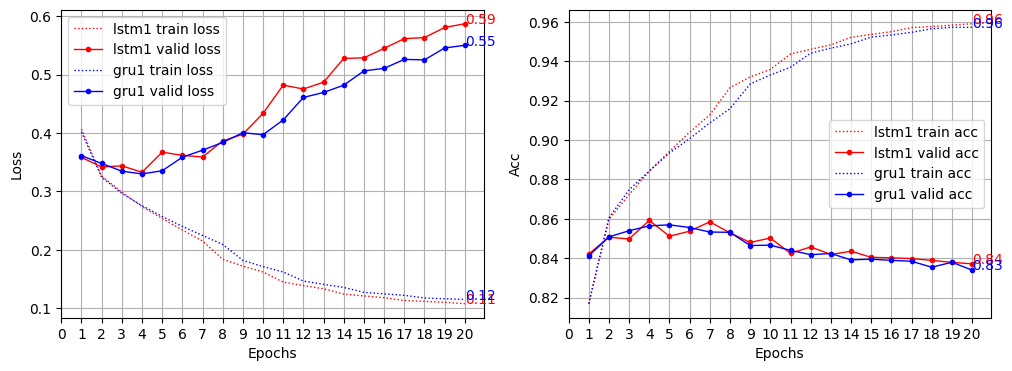

In [130]:
show_lcurve([history_lstm1, history_gru1], ["lstm1","gru1"],["r","b"])

### 5. LSTM MTM

In [133]:
model = tf.keras.Sequential(name="LSTM_MTM")
model.add(tf.keras.layers.Input(shape=MAXLEN))
model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=WORD_VECTOR_DIM))
model.add(tf.keras.layers.LSTM(100, return_sequences=True, name="LSTM1"))
model.add(tf.keras.layers.LSTM(100, return_sequences=True, name="LSTM2"))
model.add(tf.keras.layers.LSTM(100, name="LSTM3"))

model.add(tf.keras.layers.Dense(1, activation="sigmoid", name="classifier"))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_acc",
                                        patience=3,
                                        factor=0.5)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])
model.summary()

Model: "LSTM_MTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 47, 300)           3000000   
                                                                 
 LSTM1 (LSTM)                (None, 47, 100)           160400    
                                                                 
 LSTM2 (LSTM)                (None, 47, 100)           80400     
                                                                 
 LSTM3 (LSTM)                (None, 100)               80400     
                                                                 
 classifier (Dense)          (None, 1)                 101       
                                                                 
Total params: 3,321,301
Trainable params: 3,321,301
Non-trainable params: 0
_________________________________________________________________


In [134]:
epochs=20

history_lstm_mtm = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr],
                    verbose=1)

Epoch 1/20
199/199 [==============================] - 10s 35ms/step - loss: 0.4218 - acc: 0.8034 - val_loss: 0.3640 - val_acc: 0.8402 - lr: 0.0010
Epoch 2/20
199/199 [==============================] - 6s 31ms/step - loss: 0.3243 - acc: 0.8598 - val_loss: 0.3412 - val_acc: 0.8503 - lr: 0.0010
Epoch 3/20
199/199 [==============================] - 6s 32ms/step - loss: 0.2919 - acc: 0.8757 - val_loss: 0.3551 - val_acc: 0.8478 - lr: 0.0010
Epoch 4/20
199/199 [==============================] - 6s 31ms/step - loss: 0.2639 - acc: 0.8898 - val_loss: 0.3302 - val_acc: 0.8597 - lr: 0.0010
Epoch 5/20
199/199 [==============================] - 6s 31ms/step - loss: 0.2401 - acc: 0.9007 - val_loss: 0.3709 - val_acc: 0.8412 - lr: 0.0010
Epoch 6/20
199/199 [==============================] - 6s 31ms/step - loss: 0.2192 - acc: 0.9100 - val_loss: 0.3521 - val_acc: 0.8516 - lr: 0.0010
Epoch 7/20
199/199 [==============================] - 6s 31ms/step - loss: 0.1991 - acc: 0.9199 - val_loss: 0.3922 - val_ac

### **6. GRU MTM**

In [39]:
model = tf.keras.Sequential(name="LSTM_MTM")
model.add(tf.keras.layers.Input(shape=MAXLEN))
model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=WORD_VECTOR_DIM))
model.add(tf.keras.layers.GRU(100, return_sequences=True, name="GRU1"))
model.add(tf.keras.layers.GRU(100, return_sequences=True, name="GRU2"))
model.add(tf.keras.layers.GRU(100, name="GRU3"))

model.add(tf.keras.layers.Dense(1, activation="sigmoid", name="classifier"))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_acc",
                                        patience=3,
                                        factor=0.5)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])
model.summary()

Model: "LSTM_MTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 47, 300)           3000000   
                                                                 
 GRU1 (GRU)                  (None, 47, 100)           120600    
                                                                 
 GRU2 (GRU)                  (None, 47, 100)           60600     
                                                                 
 GRU3 (GRU)                  (None, 100)               60600     
                                                                 
 classifier (Dense)          (None, 1)                 101       
                                                                 
Total params: 3,241,901
Trainable params: 3,241,901
Non-trainable params: 0
_________________________________________________________________


In [40]:
epochs=20

history_gru_mtm = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr],
                    verbose=1)

Epoch 1/20
199/199 [==============================] - 11s 32ms/step - loss: 0.4021 - acc: 0.8150 - val_loss: 0.3659 - val_acc: 0.8368 - lr: 0.0010
Epoch 2/20
199/199 [==============================] - 6s 29ms/step - loss: 0.3208 - acc: 0.8632 - val_loss: 0.3402 - val_acc: 0.8513 - lr: 0.0010
Epoch 3/20
199/199 [==============================] - 6s 28ms/step - loss: 0.2903 - acc: 0.8779 - val_loss: 0.3238 - val_acc: 0.8591 - lr: 0.0010
Epoch 4/20
199/199 [==============================] - 6s 29ms/step - loss: 0.2650 - acc: 0.8903 - val_loss: 0.3285 - val_acc: 0.8602 - lr: 0.0010
Epoch 5/20
199/199 [==============================] - 6s 28ms/step - loss: 0.2445 - acc: 0.9001 - val_loss: 0.3433 - val_acc: 0.8566 - lr: 0.0010
Epoch 6/20
199/199 [==============================] - 5s 28ms/step - loss: 0.2269 - acc: 0.9082 - val_loss: 0.3554 - val_acc: 0.8490 - lr: 0.0010
Epoch 7/20
199/199 [==============================] - 6s 28ms/step - loss: 0.2088 - acc: 0.9164 - val_loss: 0.3583 - val_ac

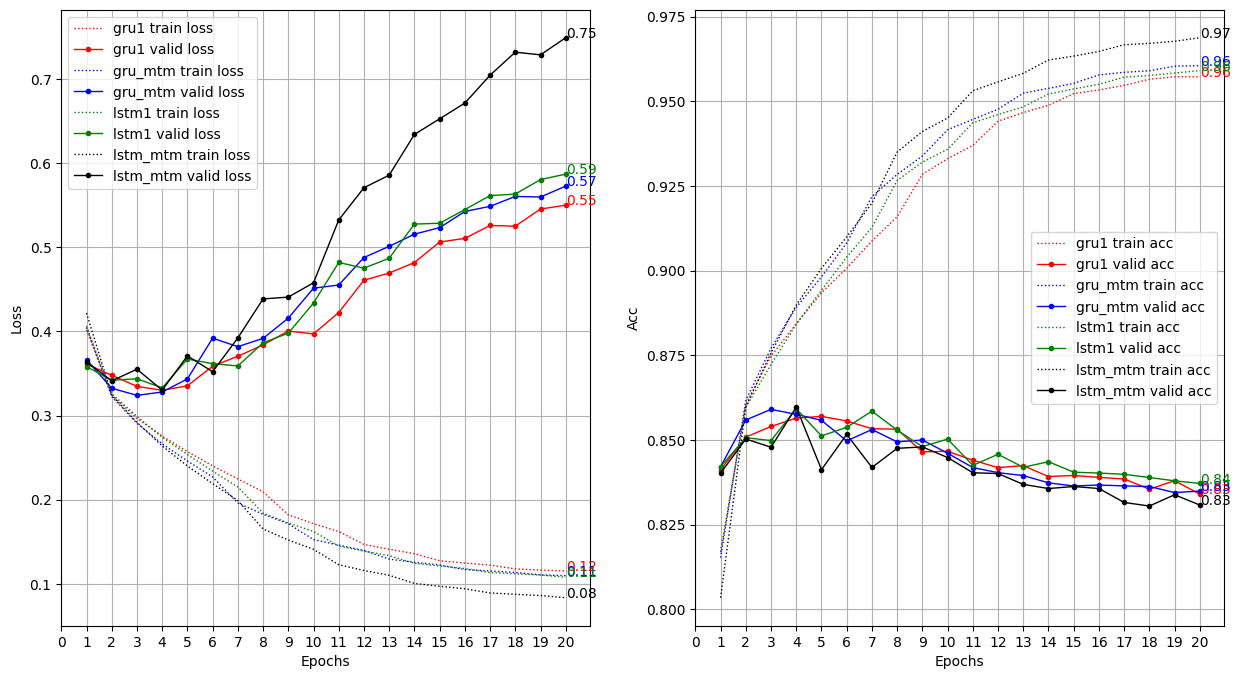

In [142]:
show_lcurve([history_gru1, history_gru_mtm,history_lstm1, history_lstm_mtm], ["gru1","gru_mtm","lstm1","lstm_mtm"],["r","b","g","k"],size=(15,8))

### 7. GRU mtm bidirectional

In [151]:
model = tf.keras.Sequential(name="LSTM_MTM")
model.add(tf.keras.layers.Input(shape=MAXLEN))
model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=WORD_VECTOR_DIM))
model.add(tf.keras.layers.Bidirectional( tf.keras.layers.GRU(100, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional( tf.keras.layers.GRU(100, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional( tf.keras.layers.GRU(100)))

model.add(tf.keras.layers.Dense(1, activation="sigmoid", name="classifier"))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_acc",
                                        patience=3,
                                        factor=0.5)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])
model.summary()

Model: "LSTM_MTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 47, 300)           3000000   
                                                                 
 bidirectional_7 (Bidirectio  (None, 47, 200)          241200    
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 47, 200)          181200    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 200)              181200    
 nal)                                                            
                                                                 
 classifier (Dense)          (None, 1)                 201       
                                                          

In [152]:
epochs=20

history_bi_gru = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr],
                    verbose=1)

Epoch 1/20
199/199 [==============================] - 18s 61ms/step - loss: 0.4074 - acc: 0.8136 - val_loss: 0.3516 - val_acc: 0.8452 - lr: 0.0010
Epoch 2/20
199/199 [==============================] - 11s 55ms/step - loss: 0.3221 - acc: 0.8624 - val_loss: 0.3392 - val_acc: 0.8556 - lr: 0.0010
Epoch 3/20
199/199 [==============================] - 11s 55ms/step - loss: 0.2855 - acc: 0.8804 - val_loss: 0.3392 - val_acc: 0.8552 - lr: 0.0010
Epoch 4/20
199/199 [==============================] - 11s 55ms/step - loss: 0.2585 - acc: 0.8928 - val_loss: 0.3538 - val_acc: 0.8569 - lr: 0.0010
Epoch 5/20
199/199 [==============================] - 11s 54ms/step - loss: 0.2361 - acc: 0.9037 - val_loss: 0.3571 - val_acc: 0.8537 - lr: 0.0010
Epoch 6/20
199/199 [==============================] - 11s 54ms/step - loss: 0.2173 - acc: 0.9133 - val_loss: 0.3668 - val_acc: 0.8489 - lr: 0.0010
Epoch 7/20
199/199 [==============================] - 11s 54ms/step - loss: 0.1986 - acc: 0.9212 - val_loss: 0.3766 - 

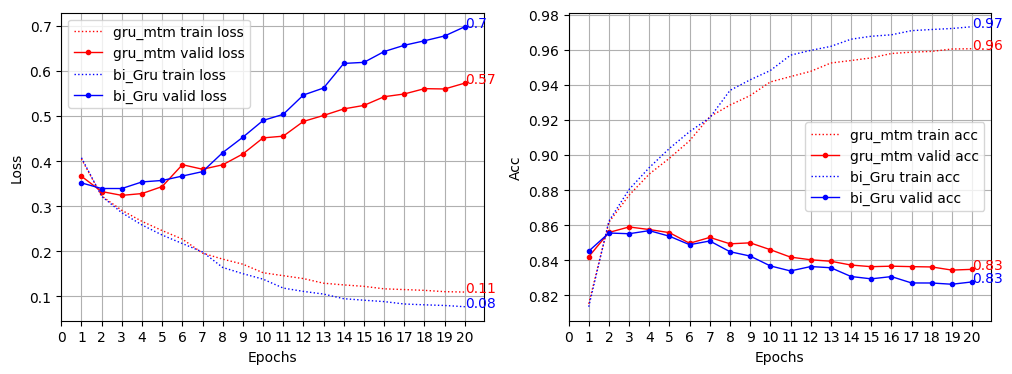

In [153]:
show_lcurve([history_gru_mtm, history_bi_gru], ["gru_mtm","bi_Gru"],["r","b"])

8 . GRU mtm + GMP ( No import embedding )

In [157]:
model = tf.keras.Sequential(name="LSTM_MTM_GMP")
model.add(tf.keras.layers.Input(shape=MAXLEN))
model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=WORD_VECTOR_DIM))
model.add(tf.keras.layers.GRU(100, return_sequences=True))
model.add(tf.keras.layers.GRU(100, return_sequences=True))
model.add(tf.keras.layers.GRU(100, return_sequences=True))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(1, activation="sigmoid", name="classifier"))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_acc",
                                        patience=3,
                                        factor=0.5)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])
model.summary()

Model: "LSTM_MTM_GMP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 47, 300)           3000000   
                                                                 
 gru_13 (GRU)                (None, 47, 100)           120600    
                                                                 
 gru_14 (GRU)                (None, 47, 100)           60600     
                                                                 
 gru_15 (GRU)                (None, 47, 100)           60600     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 classifier (Dense)          (None, 1)                 101       
                                                      

In [158]:
epochs=20

history_gru_gmp = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr],
                    verbose=1)

Epoch 1/20
199/199 [==============================] - 10s 34ms/step - loss: 0.4131 - acc: 0.8078 - val_loss: 0.3719 - val_acc: 0.8379 - lr: 0.0010
Epoch 2/20
199/199 [==============================] - 6s 29ms/step - loss: 0.3277 - acc: 0.8593 - val_loss: 0.3378 - val_acc: 0.8531 - lr: 0.0010
Epoch 3/20
199/199 [==============================] - 6s 29ms/step - loss: 0.2966 - acc: 0.8741 - val_loss: 0.3293 - val_acc: 0.8574 - lr: 0.0010
Epoch 4/20
199/199 [==============================] - 6s 30ms/step - loss: 0.2751 - acc: 0.8838 - val_loss: 0.3255 - val_acc: 0.8595 - lr: 0.0010
Epoch 5/20
199/199 [==============================] - 6s 30ms/step - loss: 0.2556 - acc: 0.8936 - val_loss: 0.3265 - val_acc: 0.8595 - lr: 0.0010
Epoch 6/20
199/199 [==============================] - 6s 29ms/step - loss: 0.2379 - acc: 0.9029 - val_loss: 0.3428 - val_acc: 0.8577 - lr: 0.0010
Epoch 7/20
199/199 [==============================] - 6s 29ms/step - loss: 0.2212 - acc: 0.9109 - val_loss: 0.3479 - val_ac

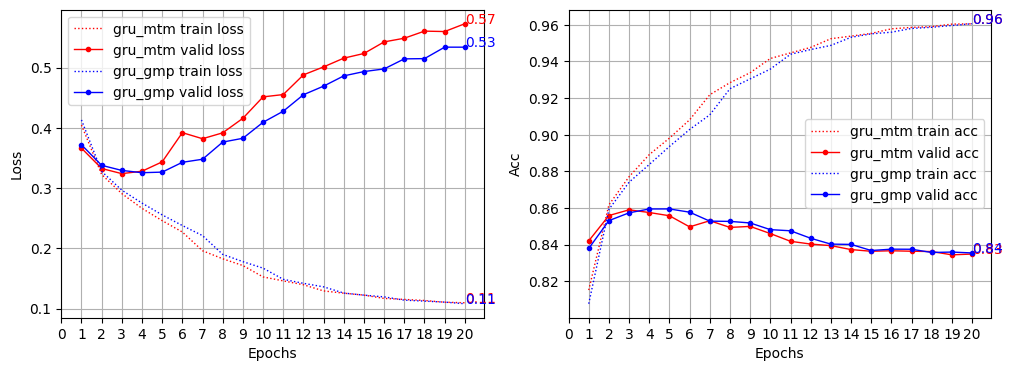

In [159]:
show_lcurve([history_gru_mtm, history_gru_gmp], ["gru_mtm","gru_gmp"],["r","b"])

### 8. GRU mtm gmp dopout

In [165]:
model = tf.keras.Sequential(name="GRU_GMP_DROP")
model.add(tf.keras.layers.Input(shape=MAXLEN))
model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=WORD_VECTOR_DIM))
model.add(tf.keras.layers.GRU(100, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GRU(100, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GRU(100, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(1, activation="sigmoid", name="classifier"))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_acc",
                                        patience=3,
                                        factor=0.5)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])
model.summary()

Model: "GRU_GMP_DROP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 47, 300)           3000000   
                                                                 
 gru_25 (GRU)                (None, 47, 100)           120600    
                                                                 
 dropout_3 (Dropout)         (None, 47, 100)           0         
                                                                 
 gru_26 (GRU)                (None, 47, 100)           60600     
                                                                 
 dropout_4 (Dropout)         (None, 47, 100)           0         
                                                                 
 gru_27 (GRU)                (None, 47, 100)           60600     
                                                                 
 dropout_5 (Dropout)         (None, 47, 100)          

In [166]:
epochs=20

history_gru_gmp_drop = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr],
                    verbose=1)

Epoch 1/20
199/199 [==============================] - 10s 35ms/step - loss: 0.4279 - acc: 0.7988 - val_loss: 0.3737 - val_acc: 0.8391 - lr: 0.0010
Epoch 2/20
199/199 [==============================] - 6s 30ms/step - loss: 0.3284 - acc: 0.8592 - val_loss: 0.3491 - val_acc: 0.8520 - lr: 0.0010
Epoch 3/20
199/199 [==============================] - 6s 30ms/step - loss: 0.2969 - acc: 0.8738 - val_loss: 0.3453 - val_acc: 0.8475 - lr: 0.0010
Epoch 4/20
199/199 [==============================] - 6s 30ms/step - loss: 0.2757 - acc: 0.8856 - val_loss: 0.3342 - val_acc: 0.8584 - lr: 0.0010
Epoch 5/20
199/199 [==============================] - 6s 29ms/step - loss: 0.2571 - acc: 0.8943 - val_loss: 0.3306 - val_acc: 0.8566 - lr: 0.0010
Epoch 6/20
199/199 [==============================] - 6s 29ms/step - loss: 0.2402 - acc: 0.9021 - val_loss: 0.3346 - val_acc: 0.8560 - lr: 0.0010
Epoch 7/20
199/199 [==============================] - 6s 30ms/step - loss: 0.2264 - acc: 0.9097 - val_loss: 0.3380 - val_ac

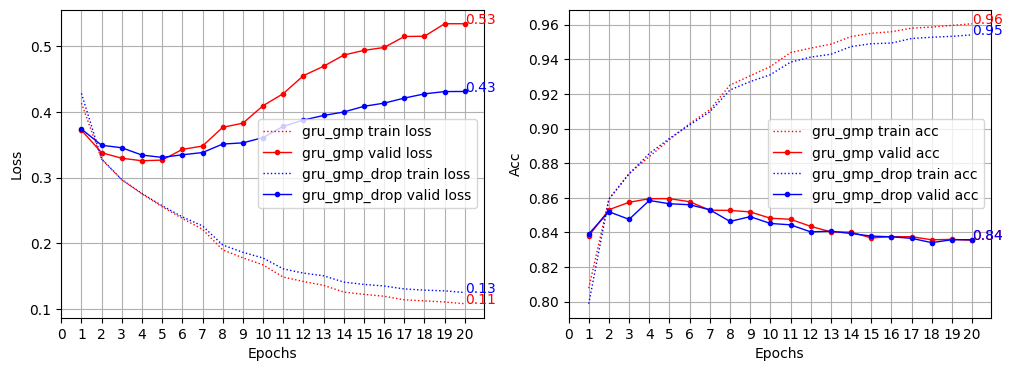

In [167]:
show_lcurve([history_gru_gmp, history_gru_gmp_drop], ["gru_gmp","gru_gmp_drop"],["r","b"])

## Word2Vec

In [42]:
word2vec_file_path = '../data/ex8/naverreview_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(VOCAB_SIZE-4, WORD_VECTOR_DIM))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,VOCAB_SIZE):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [47]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['명작']
print("vector shape : ", vector.shape)
print(vector)

vector shape :  (300,)
[ 0.07085613 -0.09554909 -0.06027709  0.0905529   0.09519945 -0.00847269
  0.10904942 -0.10300437 -0.05232102  0.07324877  0.09324132  0.10646171
  0.08613355 -0.03368443 -0.01995334  0.04656927 -0.0675032   0.04216389
 -0.10969331  0.08160848  0.03027424 -0.06052775  0.11573355  0.0850665
  0.06348047  0.10779229  0.176831   -0.17802028  0.10358786 -0.1805172
 -0.11206757 -0.10562011 -0.09933143  0.11460371 -0.10941713  0.00879673
  0.08575831 -0.14680867  0.12840337 -0.1272448  -0.08019616 -0.09847051
  0.10383581 -0.10760821  0.12314884 -0.11032974 -0.0942532  -0.17225336
  0.12563537  0.06996328 -0.08069818  0.13056661  0.09366535 -0.11081504
  0.17468493 -0.03384265  0.12056248  0.09438738  0.057436    0.0502269
  0.03587055 -0.05062448 -0.10110355 -0.03675716  0.11485282  0.11485142
 -0.05742555 -0.16105586  0.07498898 -0.15669039 -0.04697832  0.03353336
  0.13828577  0.03580339  0.11846644 -0.15876864 -0.11953074 -0.09181884
  0.08756717  0.01225668  0.117

In [46]:
word_vectors.similar_by_word("명작")

[('수작', 0.9033554196357727),
 ('일품', 0.9023584127426147),
 ('멋져', 0.9010695815086365),
 ('귀여워', 0.8990427851676941),
 ('잼따', 0.8986956477165222),
 ('쵝오', 0.8949720859527588),
 ('진진', 0.8941335082054138),
 ('재밌', 0.8940634727478027),
 ('굿', 0.8938332796096802),
 ('귀여움', 0.8937718868255615)]

## import Embdding 

In [53]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path = '../data/ex8/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_path)
vector = word_vectors.wv['명작']
print("vector shape : ", vector.shape)
print(vector)

vector shape :  (100,)
[-1.79331183e-01 -1.59548378e+00 -2.18019986e+00  1.51119506e+00
  1.04091978e+00  1.75699854e+00 -2.03305769e+00 -5.40285349e-01
 -2.85380840e-01 -1.59715265e-01 -9.84990776e-01 -1.74767244e+00
 -1.91992414e+00 -1.00052643e+00  1.72761238e+00 -1.16873229e+00
 -1.43667924e+00 -2.74016440e-01  2.09937811e+00  1.30309938e-02
  1.87506080e-01 -1.33557647e-01  3.23735952e-01 -5.27875900e-01
  1.37758505e+00  8.77382606e-02 -1.48247874e+00  8.84171724e-01
 -1.71810281e+00 -7.26403654e-01 -1.71033692e+00  1.79145670e+00
  9.38585877e-01 -5.58272421e-01 -1.23950802e-01  3.69206727e-01
  2.04364181e-01 -2.44568896e+00  1.44292861e-01 -3.36137950e-01
 -3.75228167e-01  6.12155259e-01 -2.26090522e-03  1.29366910e+00
 -1.62971938e+00  2.24615932e+00  5.00444770e-01  1.42430067e-01
 -3.95118833e-01 -1.00489831e+00  9.15228426e-01 -3.81068558e-01
  1.58715892e+00 -4.90806133e-01 -2.43948996e-01 -3.83735746e-02
  1.09802639e+00 -1.36490619e+00  2.36269146e-01 -4.78603750e-01
  

In [55]:
word_vectors.wv.similar_by_word("명작")

[('걸작', 0.8363187909126282),
 ('대작', 0.780245840549469),
 ('거장', 0.7335883378982544),
 ('작품', 0.7322230339050293),
 ('명곡', 0.7084125280380249),
 ('그림책', 0.6971877813339233),
 ('창작물', 0.6824146509170532),
 ('희극', 0.673287570476532),
 ('인형극', 0.671007513999939),
 ('작품집', 0.6702388525009155)]

In [57]:
VOCAB_SIZE = 10000
WORD_VECTOR_DIM = 100

embedding_matrix = np.random.rand(VOCAB_SIZE, WORD_VECTOR_DIM)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,VOCAB_SIZE):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [59]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = tf.keras.Sequential(name="ko_embedding")
model.add(tf.keras.layers.Embedding(VOCAB_SIZE, 
                                 WORD_VECTOR_DIM, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=MAXLEN, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.GRU(100, return_sequences=True, name="GRU1"))
model.add(tf.keras.layers.GRU(100, return_sequences=True, name="GRU2"))
model.add(tf.keras.layers.GRU(100, name="GRU3"))

model.add(tf.keras.layers.Dense(1, activation="sigmoid", name="classifier"))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_acc",
                                        patience=3,
                                        factor=0.5)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])
model.summary()

Model: "ko_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 47, 100)           1000000   
                                                                 
 GRU1 (GRU)                  (None, 47, 100)           60600     
                                                                 
 GRU2 (GRU)                  (None, 47, 100)           60600     
                                                                 
 GRU3 (GRU)                  (None, 100)               60600     
                                                                 
 classifier (Dense)          (None, 1)                 101       
                                                                 
Total params: 1,181,901
Trainable params: 1,181,901
Non-trainable params: 0
_________________________________________________________________


In [60]:
epochs=20

history_gru_emb = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr],
                    verbose=1)

Epoch 1/20
199/199 [==============================] - 9s 32ms/step - loss: 0.4849 - acc: 0.7637 - val_loss: 0.4161 - val_acc: 0.8081 - lr: 0.0010
Epoch 2/20
199/199 [==============================] - 5s 27ms/step - loss: 0.3694 - acc: 0.8337 - val_loss: 0.3559 - val_acc: 0.8419 - lr: 0.0010
Epoch 3/20
199/199 [==============================] - 5s 27ms/step - loss: 0.3236 - acc: 0.8595 - val_loss: 0.3397 - val_acc: 0.8519 - lr: 0.0010
Epoch 4/20
199/199 [==============================] - 6s 28ms/step - loss: 0.2947 - acc: 0.8730 - val_loss: 0.3325 - val_acc: 0.8579 - lr: 0.0010
Epoch 5/20
199/199 [==============================] - 6s 28ms/step - loss: 0.2710 - acc: 0.8851 - val_loss: 0.3221 - val_acc: 0.8628 - lr: 0.0010
Epoch 6/20
199/199 [==============================] - 6s 28ms/step - loss: 0.2511 - acc: 0.8953 - val_loss: 0.3266 - val_acc: 0.8607 - lr: 0.0010
Epoch 7/20
199/199 [==============================] - 6s 28ms/step - loss: 0.2302 - acc: 0.9046 - val_loss: 0.3367 - val_acc

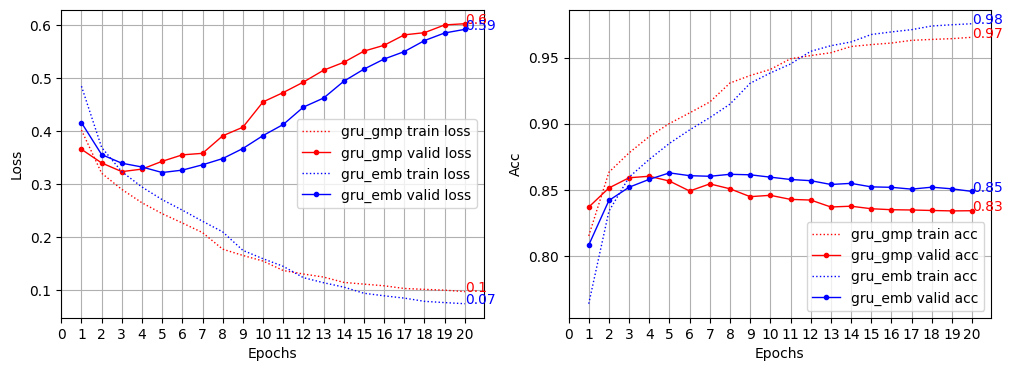

In [62]:
show_lcurve([history_gru_mtm, history_gru_emb], ["gru_gmp","gru_emb"],["r","b"])